In [1]:
import pandas as pd 
import numpy as np
import darts
import yfinance

In [2]:
raw_data = pd.read_csv('google_stock_price.csv')
raw_data

,Stock Price
0,50.12
1,54.10
2,54.65
3,52.38
4,52.95
...,...
3007,772.88
3008,771.07
3009,773.18
3010,771.61


In [4]:
#rsi
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

raw_data['rsi_14'] = get_rsi(raw_data['Stock Price'], 14)

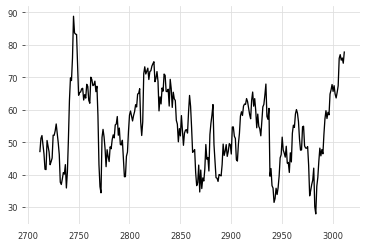

In [5]:
raw_data[-300:].rsi_14.plot();

In [6]:
data =raw_data.reset_index(drop=True)
data

,Stock Price,rsi_14
0,50.12,NaN
1,54.10,NaN
2,54.65,NaN
3,52.38,NaN
4,52.95,95.586993
...,...,...
3007,772.88,76.989186
3008,771.07,75.283476
3009,773.18,75.952338
3010,771.61,74.340299


In [7]:
data = data['rsi_14']

In [8]:
data = data.dropna()

In [9]:
data = pd.DataFrame(data)
data = data.reset_index(drop=True)
data

,rsi_14
0,95.586993
1,95.679533
2,93.719022
3,89.094433
4,89.144596
...,...
3003,76.989186
3004,75.283476
3005,75.952338
3006,74.340299


In [10]:
data['Weekly_rsi_14']=data[::5]

In [11]:
data  = data.fillna(method='ffill')
data

,rsi_14,Weekly_rsi_14
0,95.586993,95.586993
1,95.679533,95.586993
2,93.719022,95.586993
3,89.094433,95.586993
4,89.144596,95.586993
...,...,...
3003,76.989186,65.345885
3004,75.283476,65.345885
3005,75.952338,75.952338
3006,74.340299,75.952338


In [12]:
train,val= data[:2500],data[2500:]

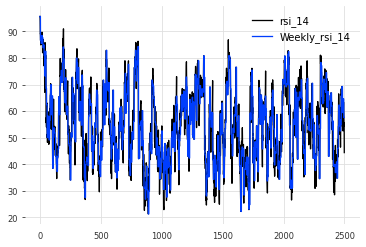

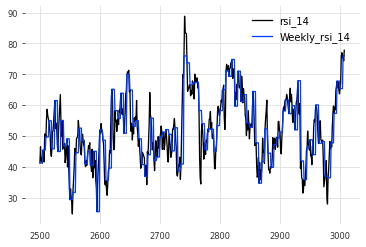

In [13]:
train.plot()
val.plot();

In [14]:
from darts.timeseries import TimeSeries

In [15]:
train = TimeSeries.from_dataframe(train, time_col=None, value_cols=None, fill_missing_dates=False, freq='B', fillna_value=None)
train

<TimeSeries (DataArray) (time: 2500, component: 2, sample: 1)>
array([[[95.58699277],
        [95.58699277]],

       [[95.67953339],
        [95.58699277]],

       [[93.71902246],
        [95.58699277]],

       ...,

       [[54.4050519 ],
        [57.59657367]],

       [[55.63075237],
        [57.59657367]],

       [[44.39681433],
        [57.59657367]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2493 2494 2495 2496 2497 2498 2499
  * component  (component) object 'rsi_14' 'Weekly_rsi_14'
Dimensions without coordinates: sample

In [16]:
from darts.dataprocessing.transformers import Scaler

In [17]:
train_scaling = Scaler()

In [18]:
train_scaled = train_scaling.fit_transform(train)

In [19]:
train_scaled

<TimeSeries (DataArray) (time: 2500, component: 2, sample: 1)>
array([[[0.99875519],
        [1.        ]],

       [[1.        ],
        [1.        ]],

       [[0.97362825],
        [1.        ]],

       ...,

       [[0.44479765],
        [0.48833619]],

       [[0.46128512],
        [0.48833619]],

       [[0.31017217],
        [0.48833619]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2493 2494 2495 2496 2497 2498 2499
  * component  (component) object 'rsi_14' 'Weekly_rsi_14'
Dimensions without coordinates: sample

In [20]:
train_df,train_cov = train_scaled['rsi_14'],train_scaled['Weekly_rsi_14']

In [21]:
from darts.models.forecasting.nbeats import NBEATSModel

In [24]:
model = NBEATSModel(
    input_chunk_length=1000,
    output_chunk_length=500,
    random_state=0,
    n_epochs=10
)

In [25]:
model.fit(train_df,past_covariates=train_cov,verbose=True)

[2022-01-20 20:09:16,128] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1001 samples.
[2022-01-20 20:09:16,128] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1001 samples.
[2022-01-20 20:09:16,269] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-20 20:09:16,269] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
forecast = model.predict(n=500)

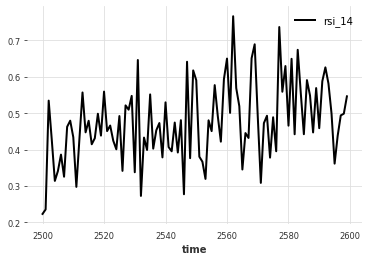

In [32]:
forecast[:100].plot();

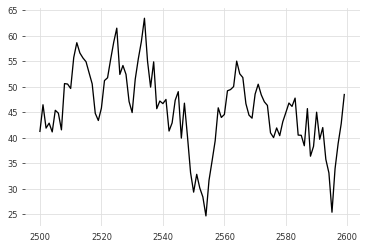

In [33]:
val.rsi_14[:100].plot();